# Install pyspark

In [19]:
!pip install pyspark --quiet

In [20]:
!pip install spark-nlp --quiet

# Les import 

In [47]:
import spacy 
from pyspark.sql import SparkSession
#import pyspark.sql.functions as F
#import pyspark.sql.types as T
from pyspark.sql.functions import col, explode
from pyspark.ml.feature import CountVectorizer
import sparknlp
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnull, isnan,count,when,trim
import pandas as pd
import matplotlib.pyplot as plt


In [48]:
#sprk_nlp = sparknlp.start()
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [49]:
# Montage drive (optionnel)
#from google.colab import drive
#drive.mount('/My_drive/')

In [50]:
!ls 

offensive_comment_small.csv  sample_data


#Load Data 

In [51]:
!ls

offensive_comment_small.csv  sample_data


In [52]:
#Charger un csv (modifier le path)
#path="/My_drive/My Drive/Cours prof Big data/2022 GIS5/Projet/offensive_comment_small.csv"
#df = spark.read.csv(path,header=True, sep=";")

data = spark.read.csv("./offensive_comment_small.csv",header=True, sep=";")

# Data Exploration

In [53]:
print((data.count(), len(data.columns)))
data.show()

(10000, 8)
+------------+--------------------+-----+------------+-------+------+------+-------------+
|          id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+------------+--------------------+-----+------------+-------+------+------+-------------+
| 86236166566|How can Ceha use ...|    0|           0|      0|     0|     0|            0|
| 67516955649|Blah... Childlove...|    0|           0|      0|     0|     0|            0|
| 22144619496|WTH DUDE Deleting...|    0|           0|      0|     0|     1|            0|
| 10428262239|"'""I''ve added a...|    0|           0|      0|     0|     0|            0|
| 82779776033|Violation Your re...|    0|           0|      0|     0|     0|            0|
| 72769334443|take care  16:55,...|    0|           0|      0|     0|     0|            0|
| 80250530594|'The second examp...|    0|           0|      0|     0|     0|            0|
| 40748094103|"'"" Bye I''m not...|    1|           0|      1|     0|     1|   

In [54]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: string (nullable = true)
 |-- severe_toxic: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- identity_hate: string (nullable = true)



On voit que le dataset contient 10000 commentaires caractérisés par 6 features. Toutes les données de notre dataset sont du type String. 

### Types Convertion 

In [55]:
for column in data.columns[2:]: 
  data = data.withColumn(column, col(column).cast("integer")) 

In [56]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



In [57]:
data.select(data.columns[2:]).describe().show()

+-------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+
|summary|              toxic|       severe_toxic|            obscene|              threat|             insult|       identity_hate|
+-------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+
|  count|               9998|               9998|               9998|                9998|               9998|                9998|
|   mean|0.20004000800160032|0.01860372074414883|0.10342068413682737|0.007401480296059212|0.09691938387677536|0.016203240648129627|
| stddev| 0.4000500098772665|0.13512752727977903|0.30452277664683985| 0.08571717025072571|0.29586275895080216| 0.12626278227790177|
|    min|                  0|                  0|                  0|                   0|                  0|                   0|
|    max|                  1|                  1|                  1|       

### A-t-on des valeurs manquantes ? 

In [58]:
data.select([count(when((col(c) == '' ) | \
                         col(c).isNull() | \
                          isnan(c), c 
                           )).alias(c)
                    for c in data.columns]).show()

+---+------------+-----+------------+-------+------+------+-------------+
| id|comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+---+------------+-----+------------+-------+------+------+-------------+
|  0|           0|    2|           2|      2|     2|     2|            2|
+---+------------+-----+------------+-------+------+------+-------------+



  On voit qu'on a 2 valeurs manquantes pour les colonnes : toxic, severe_toxic, obscene, threat, insult, identity_hate. 
  Pour la colonne comment_text on voit qu'on n'a pas de commentaires vide. 

## Traitement des valeurs manquantes

In [ ]:
# Drop rows with null values: vu qu'on en n'a pas beaucoup 
data = data.dropna()
print((data.count(), len(data.columns)))

(9998, 8)


## La colonne toxic

<AxesSubplot:xlabel='toxic'>

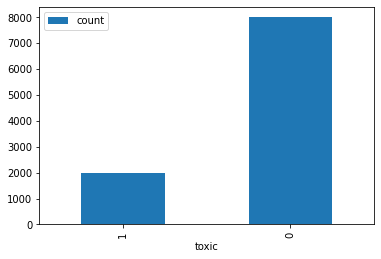

In [ ]:
data.groupBy("toxic").count().toPandas().plot(kind='bar', x='toxic', y='count')

On voit que la variable toxic est une variable binaires. On voit également que la majorité des commentairs ne sont pas toxic. 

### La colonne severe_toxic





<AxesSubplot:xlabel='severe_toxic'>

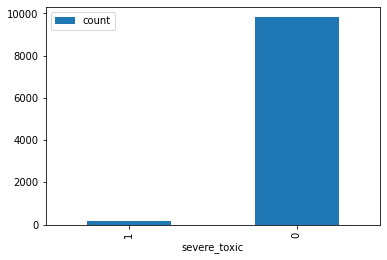

In [ ]:
data.groupBy("severe_toxic").count().toPandas().plot(kind='bar', x='severe_toxic', y='count')

On voit que la colonne severe_toxic est aussi une variable binaire, où on a aussi la plus part des commentaires qui ne sont pas des serve_toxic. 

# Y-t-il une relation entre toxic et severe_toxic ? 

In [ ]:
data.groupBy("severe_toxic", "toxic").count().show() # toPandas().plot(kind='bar', x='severe_toxic', y='count')

+------------+-----+-----+
|severe_toxic|toxic|count|
+------------+-----+-----+
|           1|    1|  186|
|           0|    0| 7998|
|           0|    1| 1814|
+------------+-----+-----+



## La colonne obscene 

<AxesSubplot:xlabel='obscene'>

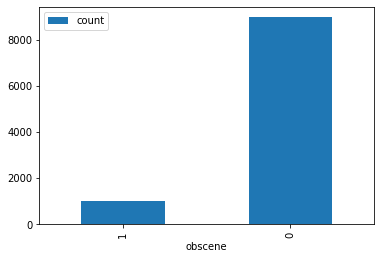

In [ ]:
data.groupBy("obscene").count().toPandas().plot(kind='bar', x='obscene', y='count')

Le nombre de commentaires non obscene est plus grand que le nombre de commentaires obscene.



### La colonne threat 

<AxesSubplot:xlabel='threat'>

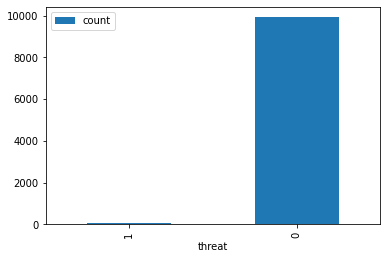

In [ ]:
data.groupBy("threat").count().toPandas().plot(kind='bar', x='threat', y='count')

La plut part des commentaires sont non threat dans notre dataset.

### La colonne insult


<AxesSubplot:xlabel='insult'>

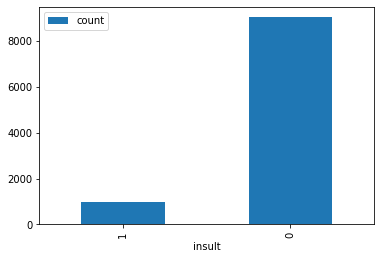

In [ ]:
data.groupBy("insult").count().toPandas().plot(kind='bar', x='insult', y='count')

La plut part des commentaires sont non insult dans notre dataset.

### La colonne identity_hate

<AxesSubplot:xlabel='identity_hate'>

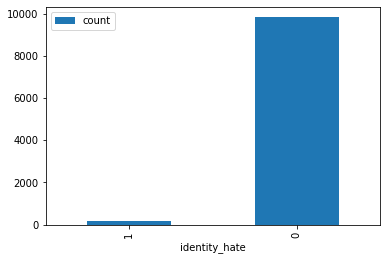

In [ ]:
data.groupBy("identity_hate").count().toPandas().plot(kind='bar', x='identity_hate', y='count')

La plut part des commentaires sont non identity_hate dans notre dataset.

### La colonne comment_text

In [29]:
data.filter(isnull(trim(col("comment_text")))).show() # pas de commentaire vide

+---+------------+-----+------------+-------+------+------+-------------+
| id|comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+---+------------+-----+------------+-------+------+------+-------------+
+---+------------+-----+------------+-------+------+------+-------------+



On voit qu'on a pas des commentaires vides. 